In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )
df = pd.read_parquet(datafile)
df.head()

,timestamp,author,message,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week
0,2015-11-04 11:28:12+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft deze groep gemaakt,False,True,43,False,worktimes,11:28:12,2
1,2017-03-31 11:58:33+00:00,Phons Berkemeijer,‎Locatie: https://maps.google.com/?q=51.378368...,False,True,2972,True,worktimes,11:58:33,4
2,2018-05-01 21:31:07+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[13-05-2018, 15:0...",False,True,4997,False,evening,21:31:07,1
3,2019-04-07 19:35:25+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[31-05-2019, 19:2...",False,True,1226,False,evening,19:35:25,6
4,2019-08-04 13:39:20+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft de groepsafbeelding g...,False,True,54,False,worktimes,13:39:20,6


<Axes: xlabel='message_length', ylabel='Count'>

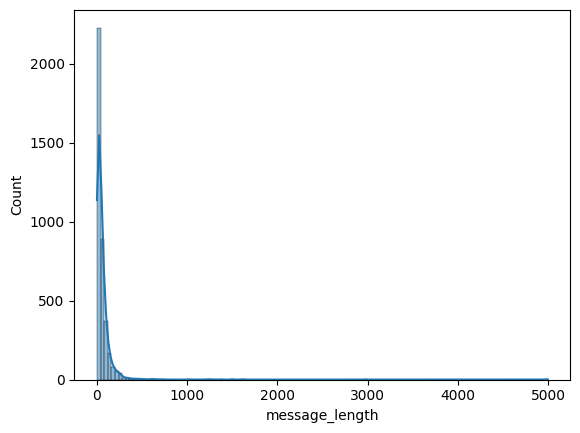

In [4]:
sns.histplot(df, x="message_length", kde=True)

<Axes: xlabel='log_len', ylabel='Count'>

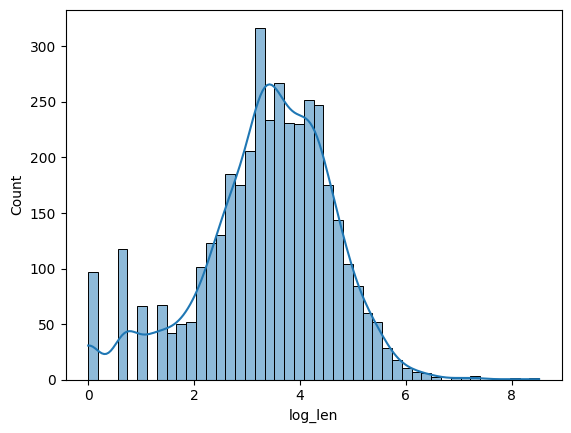

In [5]:
import numpy as np

df["log_len"] = df["message_length"].apply(lambda x: np.log(x))
sns.histplot(df, x="log_len", kde=True)

In [6]:
df.head()

,timestamp,author,message,has_emoji,is_topk,message_length,has_link,timestamp_category,hour,day_of_week,log_len
0,2015-11-04 11:28:12+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft deze groep gemaakt,False,True,43,False,worktimes,11:28:12,2,3.761200
1,2017-03-31 11:58:33+00:00,Phons Berkemeijer,‎Locatie: https://maps.google.com/?q=51.378368...,False,True,2972,True,worktimes,11:58:33,4,7.996990
2,2018-05-01 21:31:07+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[13-05-2018, 15:0...",False,True,4997,False,evening,21:31:07,1,8.516593
3,2019-04-07 19:35:25+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[31-05-2019, 19:2...",False,True,1226,False,evening,19:35:25,6,7.111512
4,2019-08-04 13:39:20+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft de groepsafbeelding g...,False,True,54,False,worktimes,13:39:20,6,3.988984


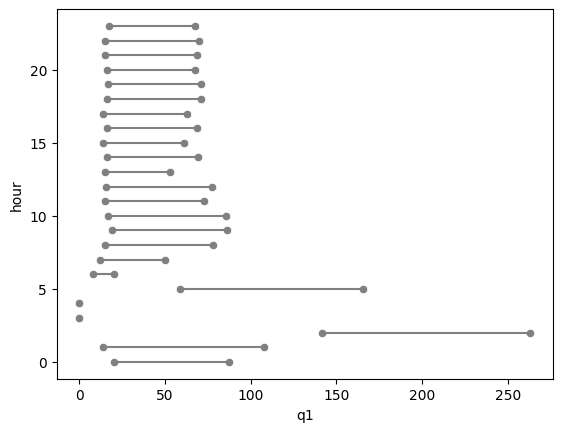

In [7]:
def q1(x):
    return np.quantile(x, 0.25)
def q3(x):
    return np.quantile(x, 0.75)

df["hour"] = df.timestamp.dt.hour
quantiles = df.groupby("hour")["message_length"].agg([q1, q3])
quantiles.columns = ["q1", "q3"]

p = quantiles.reindex(range(24), fill_value=0)

sns.scatterplot(data=p, x="q1", y=p.index, color="grey")
sns.scatterplot(data=p, x="q3", y=p.index, color="grey")
for index, row in p.iterrows():
    sns.lineplot(x=[row["q1"], row["q3"]], y=[index, index], color="grey")

Text(0.5, 1.0, 'Wanneer zijn berichten langer?')

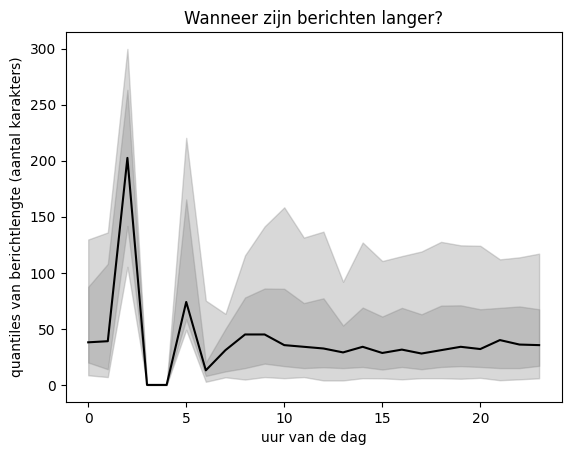

In [8]:
def q1(x):
    return np.quantile(x, 0.1)
def q2(x):
    return np.quantile(x, 0.25)
def q3(x):
    return np.quantile(x, 0.5)
def q4(x):
    return np.quantile(x, 0.75)
def q5(x):
    return np.quantile(x, 0.9)

df["hour"] = df.timestamp.dt.hour
quantiles = df.groupby("hour")["message_length"].agg([q1, q2, q3, q4, q5])
quantiles.columns = ["q1", "q2", "q3", "q4", "q5"]
p = quantiles.reindex(range(24), fill_value=0)

plt.plot(p.index, p["q3"], color="black")
plt.fill_between(p.index, p["q2"], p["q4"], color="grey", alpha=0.3)
plt.fill_between(p.index, p["q1"], p["q5"], color="grey", alpha=0.3)
plt.xlabel("uur van de dag")
plt.ylabel("quantiles van berichtlengte (aantal karakters)")
plt.title("Wanneer zijn berichten langer?")